# Dyadic Filter Banks

In [1]:
using FileIO;
using LibSndFile;
using Plots;
using DSP;
using SampledSignals;
using FixedPointNumbers;
using CUDA;
using Wavelets;

In [2]:
audio_to_float(x) = Float32.(0.5.*(x[:,1] .+ x[:,2]));
float_to_audio(x,sr) = SampleBuf(Q0f15.(x),sr);
truncate_audio(x,L) = x[1:L,:];

In [3]:
tetris = load("tetris_piano_mono.wav");
fs = round(Int,tetris.samplerate);

In [4]:
original = audio_to_float( truncate_audio(tetris.data,nextpow(2,10*fs)) );

In [5]:
float_to_audio(original,fs)

524288-frame, 1-channel SampleBuf{Q0f15, 1}
11.888616780045352s sampled at 44100.0Hz
▁▆▆▅▄▅▅▆▆▆▆▆▆▆▆▅▆▅▆▅▅▅▅▅▆▅▆▅▄▃▅▅▆▅▆▅▅▅▄▄▅▅▆▅▅▄▆▅▄▄▅▅▅▅▆▅▅▅▅▅▅▅▄▄▄▃▃▁▅▅▅▄▆▅▆▅▄▄▆▅

In [6]:
make_4d(x) = reshape(x,(size(x,1),1,1,1))
tensor(x) = CuArray(make_4d(x));
gpu_filt(h,x,p=(0,0),s=(0,0),d=(0,0)) = CUDA.CUDNN.cudnnConvolutionForward(
    h,
    x,
    padding = p,
    stride = s,
    dilation = d);
half(x) = size(x,1)÷2 + size(x,1)%2;
mag_resp(x) = 20.0 * log10.(abs.(freqz(PolynomialRatio(x,[1]))));

In [7]:
filters = [
    WT.makeqmfpair(wavelet(WT.haar)),
    WT.makereverseqmfpair(wavelet(WT.haar))
];
LA = tensor(Float32.(filters[1][1]));
HA = tensor(Float32.(filters[1][2]));
LS = tensor(Float32.(filters[2][1]));
HS = tensor(Float32.(filters[2][2]));

In [8]:
x = [tensor(original)];
num_octaves = 10;
size.(x)

1-element Vector{NTuple{4, Int64}}:
 (524288, 1, 1, 1)

# Octave Spaced Analysis Filter Bank

In [9]:
for octave ∈ 1:num_octaves
    y = cat(
        x[1:size(x,1)-1],
        [gpu_filt(HA, x[end], (1,0), 1, 1)[1:2:end-1,:,:,:]],
        [gpu_filt(LA, x[end], (1,0), 1, 1)[1:2:end-1,:,:,:]],
        dims=1)
    x = y;
end

In [10]:
size.(x)

11-element Vector{NTuple{4, Int64}}:
 (262144, 1, 1, 1)
 (131072, 1, 1, 1)
 (65536, 1, 1, 1)
 (32768, 1, 1, 1)
 (16384, 1, 1, 1)
 (8192, 1, 1, 1)
 (4096, 1, 1, 1)
 (2048, 1, 1, 1)
 (1024, 1, 1, 1)
 (512, 1, 1, 1)
 (512, 1, 1, 1)

# Balanced Analysis Filter Bank

In [11]:
for octave ∈ 1:(num_octaves+1)
    while(size(x[octave],2) < 32)
        y = hcat(
        gpu_filt(HA, x[octave], (1,0), 1, 1)[1:2:end-1,:,:,:],
        gpu_filt(LA, x[octave], (1,0), 1, 1)[1:2:end-1,:,:,:]
        );
        x[octave] = y
    end
end

In [12]:
size.(x)

11-element Vector{NTuple{4, Int64}}:
 (8192, 32, 1, 1)
 (4096, 32, 1, 1)
 (2048, 32, 1, 1)
 (1024, 32, 1, 1)
 (512, 32, 1, 1)
 (256, 32, 1, 1)
 (128, 32, 1, 1)
 (64, 32, 1, 1)
 (32, 32, 1, 1)
 (16, 32, 1, 1)
 (16, 32, 1, 1)

# Display

In [13]:
S1 = [];
S2 = [];
x_i = nothing;

for octave ∈ 1:(num_octaves+1)
    x_i = collect(x[octave][:,:]')
    h = heatmap(abs.(x_i), axis=nothing, colorbar=nothing, size=(1000,2000));
    append!(S1,[h]);
end

# Balanced Synthesis Filter Bank

In [14]:
for octave ∈ 1:(num_octaves+1)
    while(size(x[octave],2) > 1)
        ns = size(x[octave],1)*2;
        nf = size(x[octave],2)÷2;
        y = CUDA.zeros(ns, nf, 1, 1);
        y[1:2:end,:] = x[octave][:,1:nf];
        tmp = CUDA.zeros(ns, nf, 1, 1);
        tmp[1:2:end,:] = x[octave][:,nf+1:end];
        y = gpu_filt(HS, y, (1,0), 1, 1)[2:end,:,:,:] .+ gpu_filt(LS, tmp, (1,0), 1, 1)[2:end,:,:,:];
        x[octave] = y
    end
end

In [15]:
size.(x)

11-element Vector{NTuple{4, Int64}}:
 (262144, 1, 1, 1)
 (131072, 1, 1, 1)
 (65536, 1, 1, 1)
 (32768, 1, 1, 1)
 (16384, 1, 1, 1)
 (8192, 1, 1, 1)
 (4096, 1, 1, 1)
 (2048, 1, 1, 1)
 (1024, 1, 1, 1)
 (512, 1, 1, 1)
 (512, 1, 1, 1)

# Synthesis Filter Bank

In [16]:
tmp = nothing;
y = nothing;
for octave ∈ 1:num_octaves
    y = cat(
        x[1:size(x,1)-2],
        [tensor(zeros(Float32,2*size(x[end],1)))],
        dims=1)
    tmp = tensor(zeros(Float32,2*size(x[end],1)));
    y[end][1:2:end] = x[end-1];
    tmp[1:2:end] = x[end];
    y[end] = gpu_filt(HS, y[end], (1,0), 1, 1)[2:end,:,:,:] .+ gpu_filt(LS, tmp, (1,0), 1, 1)[2:end,:,:,:];
    x = y;
end

In [17]:
float_to_audio(collect(x[1][:]),fs)

524288-frame, 1-channel SampleBuf{Q0f15, 1}
11.888616780045352s sampled at 44100.0Hz
▁▆▆▅▄▅▅▆▆▆▆▆▆▆▆▅▆▅▆▅▅▅▅▅▆▅▆▅▄▃▅▅▆▅▆▅▅▅▄▄▅▅▆▅▅▄▆▅▄▄▅▅▅▅▆▅▅▅▅▅▅▅▄▄▄▃▃▁▅▅▅▄▆▅▆▅▄▄▆▅

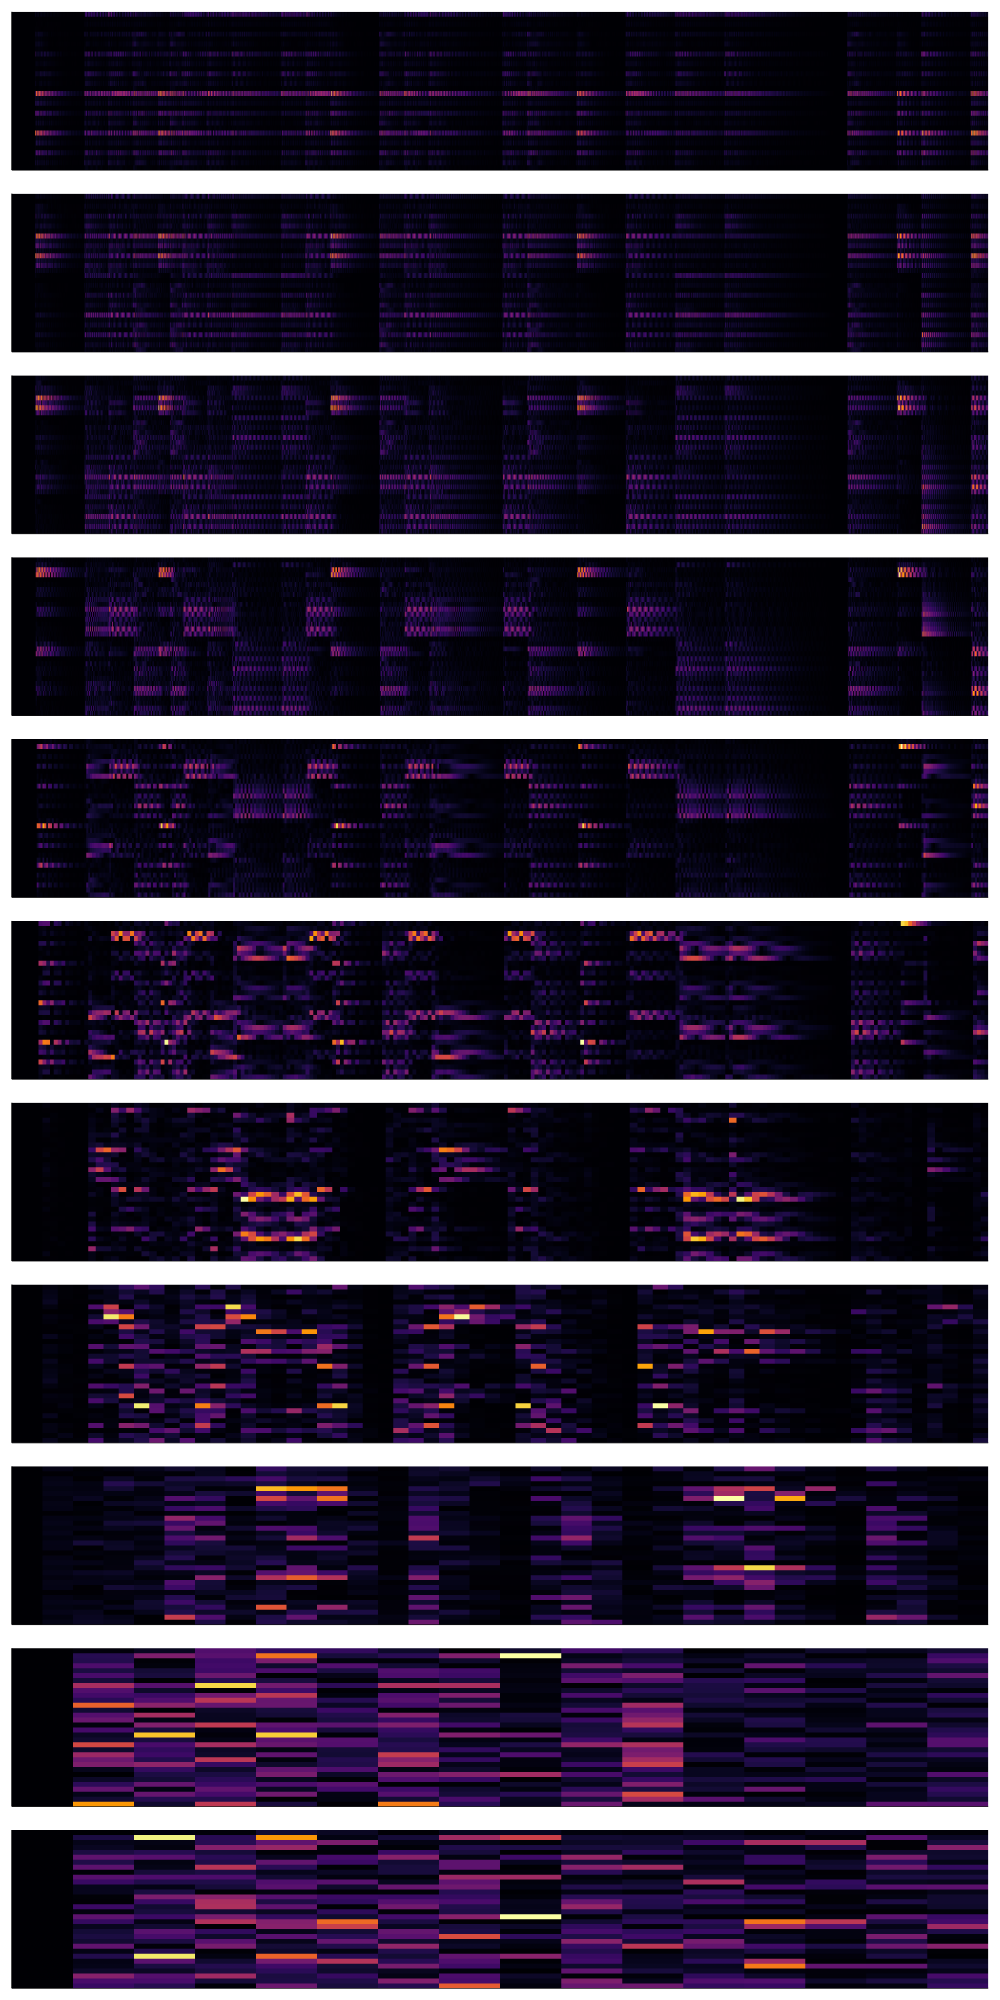

In [18]:
l = @layout [p1;p2;p3;p4;p5;p6;p7;p8;p9;p10;p11];
plot(S1..., layout=l)